## OCR 구현하기

### Overview

1. 텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다.
2. 학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다.
3. 샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다.

### Import necessary libs

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import layers, backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import re
import six
import math
import lmdb
from PIL import Image
import matplotlib.pyplot as plt
from keras_ocr.detection import Detector
from IPython.display import display
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Build data pipeline

In [2]:
class MJDatasetSequence(Sequence):
    def __init__(self, dataset_path, label_converter, batch_size=1, img_size=(100, 32), max_text_len=22, is_train=False, character=''):
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100
        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]

    def __len__(self):
        return math.ceil(self.num_samples / self.batch_size / self.divide_length)

    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)
            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')
            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            target_width = min(int(width * self.img_size[1] / height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1, 0, 2)
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]
        return img, label

    def __getitem__(self, idx):
        batch_indices = self.index_list[
            idx * self.batch_size:
            (idx + 1) * self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')
        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')
        for i, index in enumerate(batch_indices):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i, :width, :, :] = img
            labels[i, 0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        return inputs, outputs

In [3]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [4]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS

BATCH_SIZE = 128

TRAIN_DATA_PATH = 'data/MJ/MJ_train'
VALID_DATA_PATH = 'data/MJ/MJ_valid'
TEST_DATA_PATH = 'data/MJ/MJ_test'

label_converter = LabelConverter(TARGET_CHARACTERS)

### Build model

In [5]:
def ctc_lambda_func(args):
    labels, y_pred, label_length, input_length = args
    # 처음 두 개 timestep 스킵
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [6]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")([labels, y_pred, label_length, input_length])
    model_input = [image_input, labels, input_length, label_length]
    model = Model(inputs=model_input, outputs=loss_out)
    return model

In [8]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.2, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [14]:
checkpoint_path = 'aiffel/model_checkpoint.hdf5'

ckp = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True)

earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop]
)

Epoch 1/20
565/565 [==============================] - 85s 151ms/step - loss: 3.2149 - val_loss: 3.8119
Epoch 2/20
565/565 [==============================] - 85s 150ms/step - loss: 2.4787 - val_loss: 3.5322
Epoch 3/20
565/565 [==============================] - 84s 149ms/step - loss: 1.9228 - val_loss: 3.7289
Epoch 4/20
565/565 [==============================] - 84s 149ms/step - loss: 1.4817 - val_loss: 3.3958
Epoch 5/20
565/565 [==============================] - 84s 149ms/step - loss: 1.1383 - val_loss: 3.5248
Epoch 6/20
565/565 [==============================] - 84s 148ms/step - loss: 0.8655 - val_loss: 3.7124
Epoch 7/20
565/565 [==============================] - 84s 149ms/step - loss: 0.6763 - val_loss: 4.0055
Epoch 8/20
565/565 [==============================] - 84s 149ms/step - loss: 0.5280 - val_loss: 4.2236
Epoch 9/20
565/565 [==============================] - 121s 214ms/step - loss: 0.4258 - val_loss: 4.2206


### Model plotting and test

KeyError: 'accuracy'

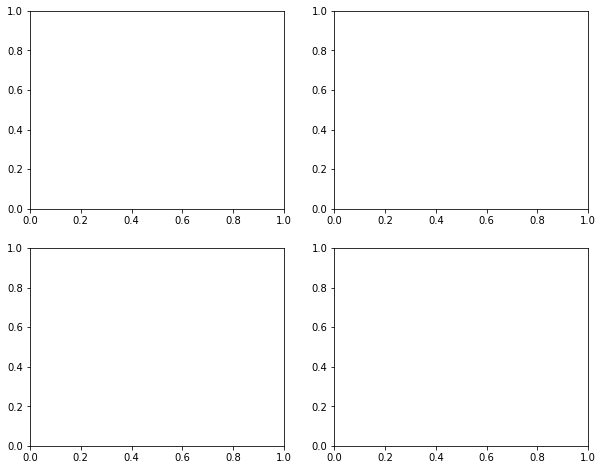

In [17]:
# 모델 train, validation 데이터 plotting
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    metrics = [('accuracy', 'Training Accuracy'), ('val_accuracy', 'Validation Accuracy'),
               ('loss', 'Training Loss'), ('val_loss', 'Validation Loss')]
    for ax, (metric, title) in zip(axes.flat, metrics):
        ax.plot(history.history[metric], label=title)
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [18]:
# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING9999999999999999


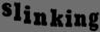

Result: 	 ALEPPO99999999999999999


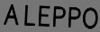

Result: 	 FWEINDE99999999999999999


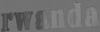

Result: 	 NATHANS99999999999999999


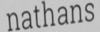

Result: 	 HALLED99999999999999999


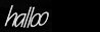

Result: 	 HURLS9999999999999999999


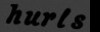

Result: 	 DOWNSIZE9999999999999999


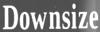

Result: 	 ROBOTIC99999999999999999


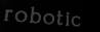

Result: 	 SLOPPY99999999999999999


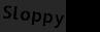

Result: 	 HERMITE99999999999999999


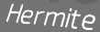

In [19]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# index개 만큼의 데이터를 읽어 모델로 inference를 수행, 결과를 디코딩해 출력
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

In [20]:
from keras_ocr.detection import Detector
SAMPLE_IMG_PATH = 'data/sample.jpg'
detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [21]:
from PIL import Image, ImageDraw
import keras_ocr

def detect_text(img_path):
    # Load the image
    img_pil = Image.open(img_path)
    
    # Initialize the OCR pipeline
    pipeline = keras_ocr.pipeline.Pipeline()
    
    # Run OCR on the image
    img = keras_ocr.tools.read(img_path)
    ocr_result = pipeline.recognize([img])[0]  # First image result
    
    # Convert to drawable image
    img_draw = ImageDraw.Draw(img_pil)
    
    # Prepare for cropping and visualization
    cropped_imgs = []
    
    # Process OCR results
    for text_result in ocr_result:
        # Draw bounding polygon
        polygon = text_result[1]  # text_result[1] is the box coordinates
        img_draw.polygon(polygon, outline='red')
        
        # Extract min/max coordinates for cropping
        x_min = polygon[:, 0].min() - 5
        x_max = polygon[:, 0].max() + 5
        y_min = polygon[:, 1].min() - 5
        y_max = polygon[:, 1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        
        # Crop the detected word region and save it
        cropped_imgs.append(img_pil.crop(word_box))
    
    # Return the result image with boxes drawn and the cropped word images
    return img_pil, cropped_imgs

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


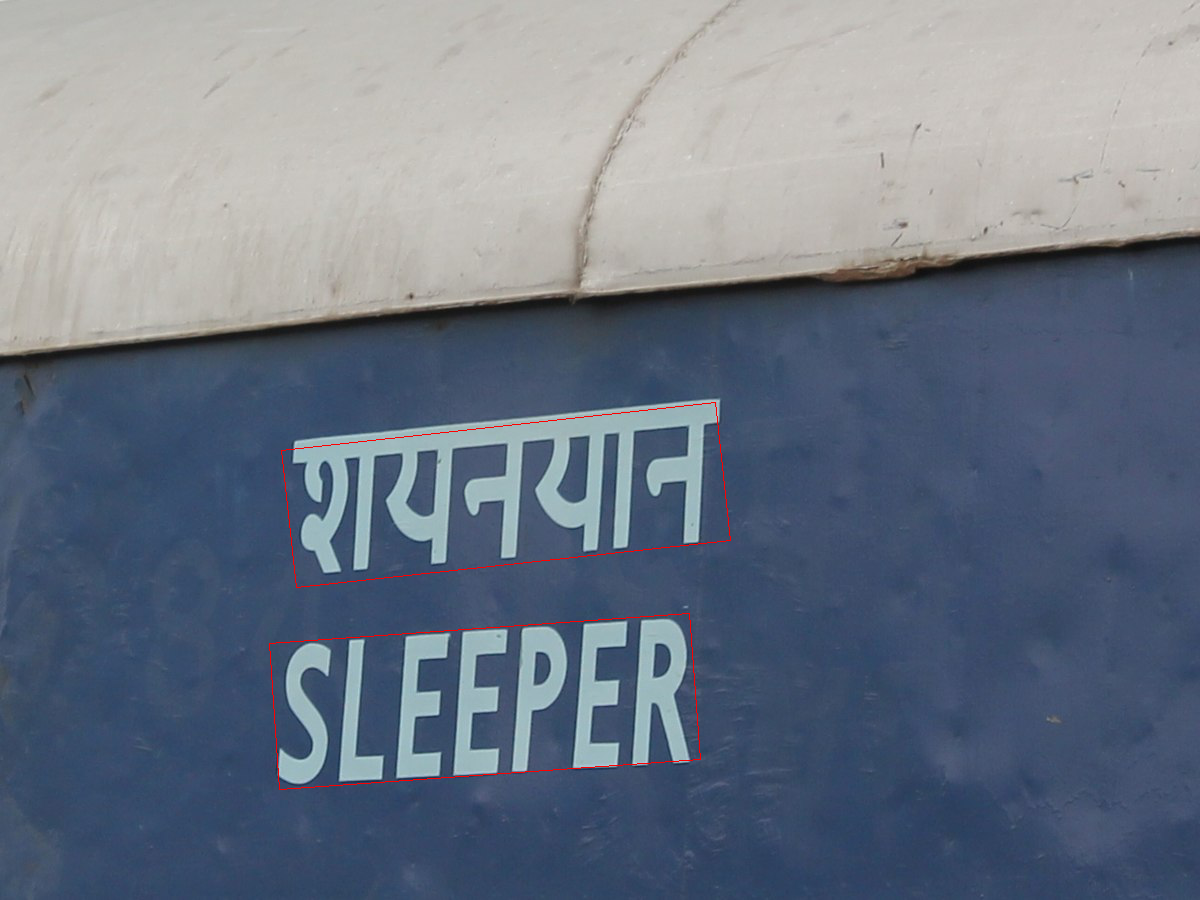

In [22]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)